# Data preparation

In [69]:
from lib import *

In [70]:
# reindex
df_wrime_target = df_wrime_target.reset_index(drop=True)
# df_wrime_target.info()

In [71]:
sentences = df_wrime_target['Sentence'].tolist()

# replace '\n' with ''
sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# replace 'x000D' with ''
sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

In [72]:
import os
path_to_embeddings = os.path.join('embeddings', 'pretrained_embeddings.tsv')

# Pre-trained model

In [73]:
def make_embeddings(sentences):
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification

    # Load pretrained model/tokenizer. 
    checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking' # 'cl-tohoku/bert-base-japanese-v2'
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, output_hidden_states=True) # output_hidden_states=True allows us to access hidden states. 

    from transformers import TRANSFORMERS_CACHE
    print(TRANSFORMERS_CACHE)


    from torch.utils.data import DataLoader

    def tokenize(text): # tokenizer function
        return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

    batch_size = 64
    dataloader = DataLoader(sentences, batch_size=batch_size, collate_fn=tokenize)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Obtain embeddings using batch processing.
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            # move batch to GPU
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            hidden_states = outputs.hidden_states
            embeddings.append(hidden_states[-1][:, 0]) # CLS token in the last layer

    embeddings = torch.cat(embeddings)
    # in 30 sec.

    # transform to dataframe object.
    df_embeddings = pd.DataFrame(embeddings.tolist())
    df_embeddings.info()
    # Save.
    df_embeddings.to_csv(path_to_embeddings, sep='\t', index=False, header=False)




# Prepare embeddings of tweets based on emotional intensities. 

In [74]:
if os.path.isfile(path_to_embeddings):
    df_embeddings = pd.read_table(path_to_embeddings, header=None)
else:
    df_embeddings = make_embeddings(sentences)

---

# K-means clustering by embeddings. 

In [75]:
from sklearn.cluster import KMeans

k = 6 # number of clusters

kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)

# Cluster ID (0-based) for each tweet. 
clusters = kmeansModel.labels_
# Cluster ID is 1-based. 
clusters = clusters + 1
print(kmeansModel.labels_)
print(len(kmeansModel.labels_))

/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[4 4 4 ... 0 4 1]
18237


In [76]:
a = 4 
b = 6

clusters[clusters == a] = -1
clusters[clusters == b] = a
clusters[clusters == -1] = b

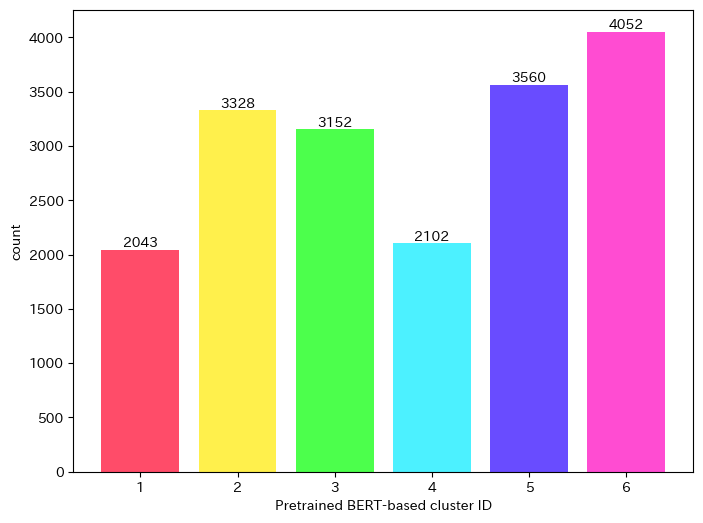

In [77]:
# setting Japanese font
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# frequency of each cluster
unique_clusters, counts = np.unique(clusters, return_counts=True)

colors = cmap(np.linspace(0, 1, len(unique_clusters)))

plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('Pretrained BERT-based cluster ID')
plt.ylabel('count')
# plt.title(f'Size of Pretrained BERT-based clusters')
plt.xticks(unique_clusters)

# Display texts
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

In [78]:
# Similarity between tweets.

from sklearn.metrics.pairwise import cosine_similarity

target_index = 1 # find similar sentences to this sentence.

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'Tweet: {row["Sentence"]}')
    print(f'Similarity = {row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'Tweet: {row["Sentence"]}')
    print(f'Similarity = {row["similarity"]}')
    print('---')

index: 1
Tweet: 今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡
Similarity = 1.0000000000000016
---
index: 7215
Tweet: そろそろ家の近く散策してみようか、と思った日に雨。 家でおとなしくしていよう。
Similarity = 0.928862047657588
---
index: 7761
Tweet: こんな時間に睡魔が…。今寝てしまったら、夜眠れなくなる…。明日は髪狩様のところに10時に行かねばならぬというのに。眠い。
Similarity = 0.9281979807444115
---
index: 14186
Tweet: 昨日から声が掠れて、きょうは少し咳が出る。夏かぜだと思いたい……。24時間冷房いれっぱなしなのできっとそうよ（誰に言う）。
Similarity = 0.9266034298205769
---
index: 13767
Tweet: 台風（；＿；）（；＿；）（；＿；）
Similarity = 0.408000915602249
---
index: 6302
Tweet: QUEEN+ADAM LAMBERTのチケット取れた！
Similarity = 0.4819761050948963
---
index: 4770
Tweet: 餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子
Similarity = 0.48752700784409875
---


/home/om/.miniconda3/envs/emotion/lib/python3.11/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


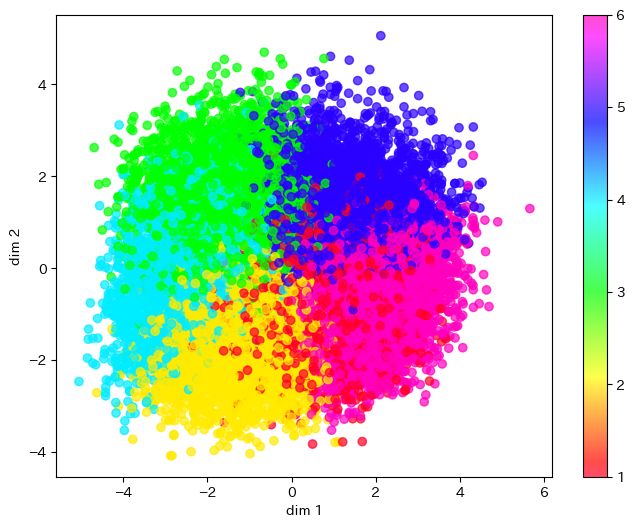

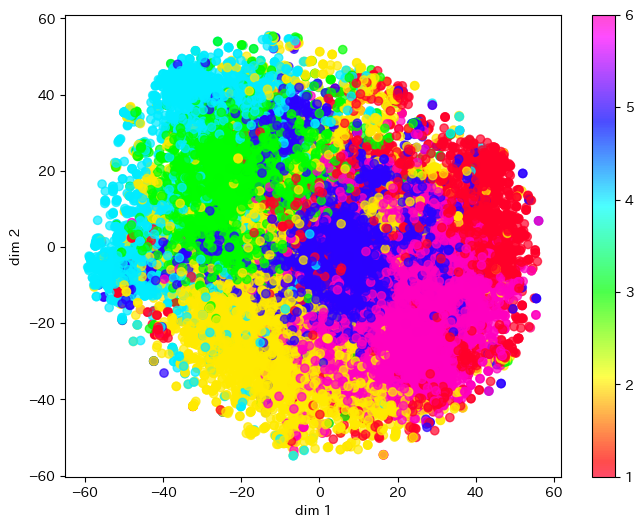

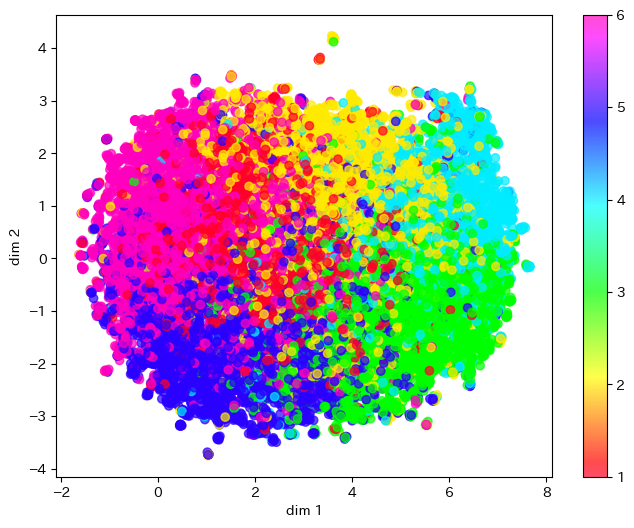

In [79]:
df_wrime_features_tsne, df_wrime_features_umap = appy_dimensionality_reduction(df_embeddings, clusters)

## Load the intensity-based clusters

In [80]:
df_clusters = pd.read_csv('clusters/emotion_6clusters.tsv', sep='\t', header=None)
emotion_clusters = df_clusters[0].tolist()
emotion_clusters = [int(x) for x in emotion_clusters]
df_intensity_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])
df_intensity_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


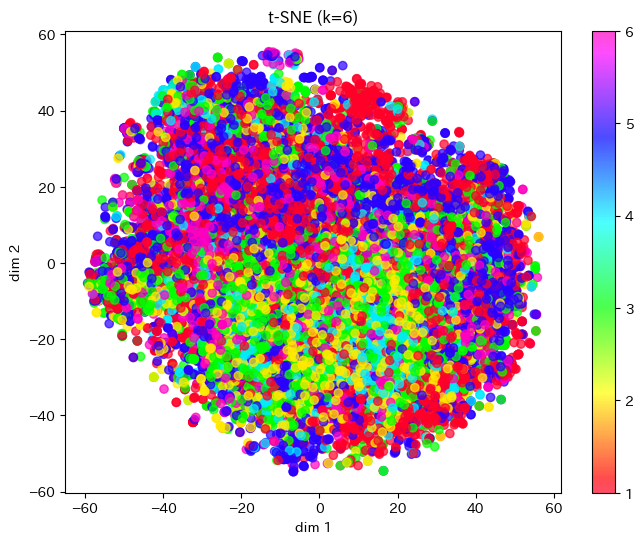

In [81]:
# t-SNE plot of the pretrained BERT-based embeddings with intensity-based cluster labels. # 吉永君正しいですよね？
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

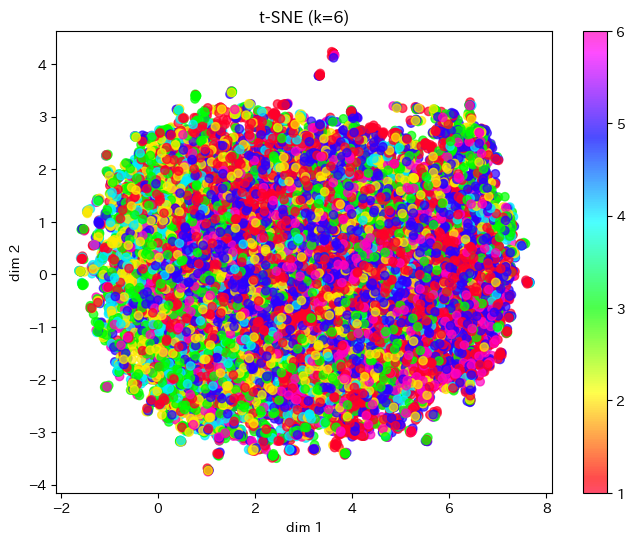

In [97]:
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

## Comparison of the embedding-based clusters with the intensity-based clusters. 

In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

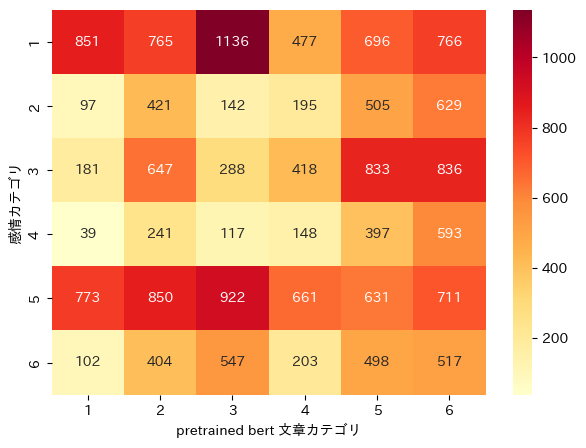

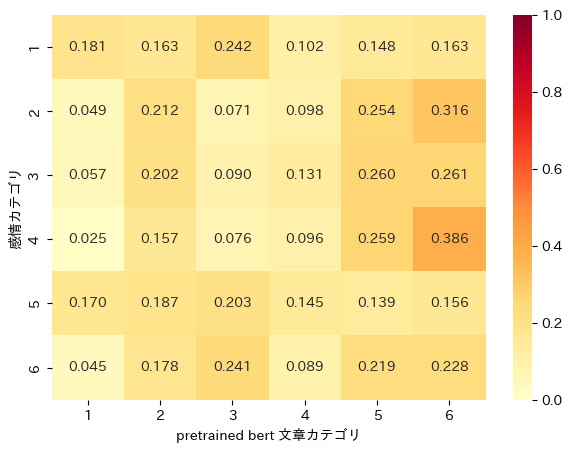

In [83]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])
# pretrained bertのクラスタリングとemotionのクラスタリングの比較
cm = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('pretrained bert 文章カテゴリ')
plt.ylabel('感情カテゴリ')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('pretrained bert 文章カテゴリ')
plt.ylabel('感情カテゴリ')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()




# Finding the optimal cluster size

In [84]:
k_max=41

In [85]:
'''
from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    SSE.append(kmeans_model.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\n\n# Survey of optimal number of clusters by Elbow Method\nSSE = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    SSE.append(kmeans_model.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), SSE, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('SSE')\nplt.title('Survey of optimal number of clusters by Elbow Method')\nplt.grid(True)\nplt.show()\n"

In [86]:
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Survey of optimal number of clusters by Silhouette Coefficient
silhouette_coefficients = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    silhouette_coefficient = silhouette_score(df_embeddings, kmeans_model.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Silhouette Coefficient')
plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\nfrom sklearn.metrics import silhouette_score\n\n# Survey of optimal number of clusters by Silhouette Coefficient\nsilhouette_coefficients = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    silhouette_coefficient = silhouette_score(df_embeddings, kmeans_model.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('Silhouette Coefficient')\nplt.title('Survey of optimal number of clusters by Silhouette Coefficient')\nplt.grid(True)\nplt.show()\n"

### Plot showing silhouette scores

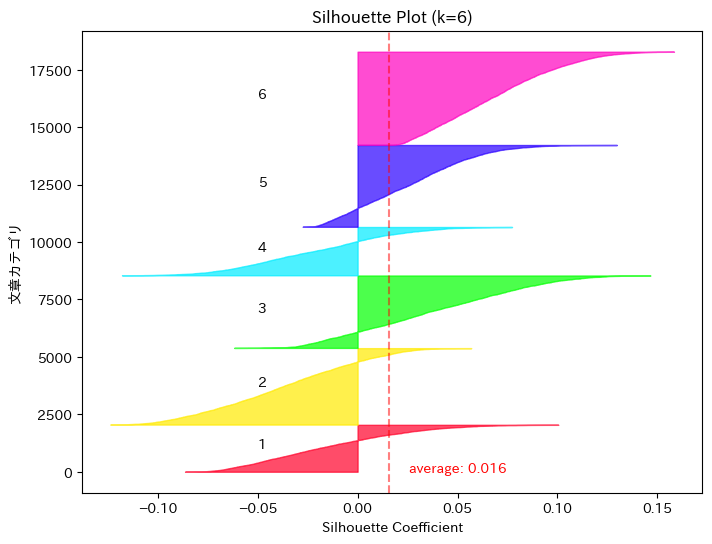

In [87]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('文章カテゴリ')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

In [88]:
# # 各文章カテゴリのシルエット係数が最も高い文章を表示
# for i, cluster in enumerate(unique_clusters):
#     cluster_silhouette_values = silhouette_values[clusters == cluster]
#     cluster_silhouette_values.sort()
#     index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
#     print(f'文章カテゴリ: {clusters[index]}')
#     print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
#     print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
#     print('---')

# The tweet with the highest silhouette coefficient in each intensity-based cluster
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'Intensity-based cluster ID: {clusters[index]}')
    print(f'The highest scored tweet: {df_wrime_target.iloc[index, 0]}')
    print(f'Silhouette score: {cluster_silhouette_values[-1]:.3f}')
    print('---')

Intensity-based cluster ID: 1
The highest scored tweet: キャスに来てくれた方、ありがとうございました。とても楽しかったです。またよろしくお願いします。
Silhouette score: 0.100
---
Intensity-based cluster ID: 2
The highest scored tweet: 4時間半渋滞からの30分ばか運転からの休憩で完全に足が震えている
Silhouette score: 0.057
---
Intensity-based cluster ID: 3
The highest scored tweet: 鍵山くん最終グループ！
Silhouette score: 0.147
---
Intensity-based cluster ID: 4
The highest scored tweet: 逃げ恥ロス(´･_･`)
Silhouette score: 0.077
---
Intensity-based cluster ID: 5
The highest scored tweet: 明日が来なければいいのに…。やだなー。
Silhouette score: 0.130
---
Intensity-based cluster ID: 6
The highest scored tweet: 勧誘にも限度がある。\n飛行機やダイビングはちょっと…。そういうタイプじゃない。オシャレ着は苦手と色々言って断ってるのに「みんな仕事は割り切ってるから」と。\nまるで私が 仕事とプライベート一緒にして働く人 みたいに言われたの意味不明。
Silhouette score: 0.158
---


In [89]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 5
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    # print(f'文章カテゴリ: {clusters[index]}')
    # print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    # print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    # print('---')

    print(f'Intensity-based cluster ID: {clusters[index]}')
    print(f'The highest scored tweet: {df_wrime_target.iloc[index, 0]}')
    print(f'Silhouette score: {cluster_silhouette_values[-1]:.3f}')
    print('---')



Intensity-based cluster ID: 5
The highest scored tweet: 明日が来なければいいのに…。やだなー。
Silhouette score: 0.130
---
Intensity-based cluster ID: 5
The highest scored tweet: ひゃー飲んだわ。さぁ帰ろう
Silhouette score: 0.130
---
Intensity-based cluster ID: 5
The highest scored tweet: あー、たのしかったー。帰って寝よっと。
Silhouette score: 0.130
---
Intensity-based cluster ID: 5
The highest scored tweet: ロキソニンを飲んで出陣です！よしどっか行くぞ。でもまだ火曜なんよね。
Silhouette score: 0.130
---
Intensity-based cluster ID: 5
The highest scored tweet: あー眠い。仕事行かんと。
Silhouette score: 0.130
---


---

---

### From the embeddings of tweets generated by the pretrained BERT model, infer the intensity-based cluster IDs

In [90]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clusters], ignore_index=True, axis=1)
# df_embeddings_clustersの最後の列を1引く
df_embeddings_clusters.iloc[:, -1] = df_embeddings_clusters.iloc[:, -1] - 1

df_embeddings_clusters

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,-0.187809,-0.029080,-0.679695,-0.096202,-0.572932,0.123853,0.143043,-0.762576,0.458638,...,-0.237780,0.491252,-0.419029,-0.075512,-0.592341,0.193195,-0.133851,0.135611,-0.031739,2
1,train,-0.149567,-0.022400,-0.615799,0.016267,-0.396527,-0.197780,0.109518,-0.546293,0.597835,...,-0.025395,0.147794,-0.278225,0.022704,-0.668021,0.255528,0.133077,0.328987,0.117896,5
2,train,-0.311793,-0.270892,-0.197350,-0.209051,-0.546432,-0.014661,0.223734,-0.550871,0.491359,...,0.278841,0.185260,-0.336378,-0.075835,-0.622448,0.380932,0.119956,0.142895,0.248715,4
3,train,-0.630534,-0.395861,-0.183580,-0.364227,-0.412567,-0.315360,-0.353432,-0.409644,0.250649,...,0.360706,0.126539,0.019109,-0.378567,-0.260029,0.320159,-0.078728,-0.447909,0.303627,0
4,train,0.077433,0.486812,0.400255,-0.118953,-0.420789,0.276861,0.175705,0.012406,0.381621,...,0.290340,0.316523,-0.422998,0.154457,-0.203230,0.572079,-0.196266,-0.114936,0.165855,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,-0.288924,0.319023,-0.429705,-0.029304,-0.243831,0.229808,-0.113894,-0.732758,0.600182,...,0.425314,0.353565,-0.236653,0.096987,-0.999827,0.198944,-0.019931,-0.009790,-0.119332,4
18233,train,-0.327183,-0.221621,-0.274371,-0.190153,-0.431822,-0.151049,0.060120,-0.462810,0.205817,...,0.037315,0.130066,-0.308815,-0.070381,-0.394315,0.068152,0.288643,0.008393,0.222475,0
18234,train,0.102690,-0.025694,-0.271076,0.076021,-0.719141,0.682369,0.045201,-0.750724,0.689253,...,0.030530,0.396863,-0.217961,-0.128606,-0.140059,0.032060,0.099945,-0.035581,-0.036848,4
18235,train,-0.268050,-0.145745,-0.345430,-0.191061,-0.564122,0.209360,0.113147,-0.819570,0.528345,...,-0.101580,0.615845,-0.222007,-0.145952,-0.723587,0.322433,-0.116301,-0.174401,-0.027152,0


In [91]:
# divide into train and test
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [92]:
import xgboost as xgb

# Make input data to xgboost
train_data = df_train.drop([0, 769], axis=1).values
train_labels = df_train[769].values

test_data = df_test.drop([0, 769], axis=1).values
test_labels = df_test[769].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.70520	test-mlogloss:1.67904
[1]	train-mlogloss:1.65303	test-mlogloss:1.60130
[2]	train-mlogloss:1.61655	test-mlogloss:1.56129
[3]	train-mlogloss:1.58781	test-mlogloss:1.52737
[4]	train-mlogloss:1.56406	test-mlogloss:1.50072
[5]	train-mlogloss:1.54417	test-mlogloss:1.47719
[6]	train-mlogloss:1.52660	test-mlogloss:1.45505
[7]	train-mlogloss:1.51047	test-mlogloss:1.43879
[8]	train-mlogloss:1.49566	test-mlogloss:1.42078
[9]	train-mlogloss:1.48185	test-mlogloss:1.40771
[10]	train-mlogloss:1.46898	test-mlogloss:1.40043
[11]	train-mlogloss:1.45756	test-mlogloss:1.38948
[12]	train-mlogloss:1.44680	test-mlogloss:1.37782
[13]	train-mlogloss:1.43657	test-mlogloss:1.36796
[14]	train-mlogloss:1.42723	test-mlogloss:1.35974
[15]	train-mlogloss:1.41832	test-mlogloss:1.35106
[16]	train-mlogloss:1.40999	test-mlogloss:1.34361
[17]	train-mlogloss:1.40214	test-mlogloss:1.33731
[18]	train-mlogloss:1.39476	test-mlogloss:1.32977
[19]	train-mlogloss:1.38759	test-mlogloss:1.32315
[20]	train

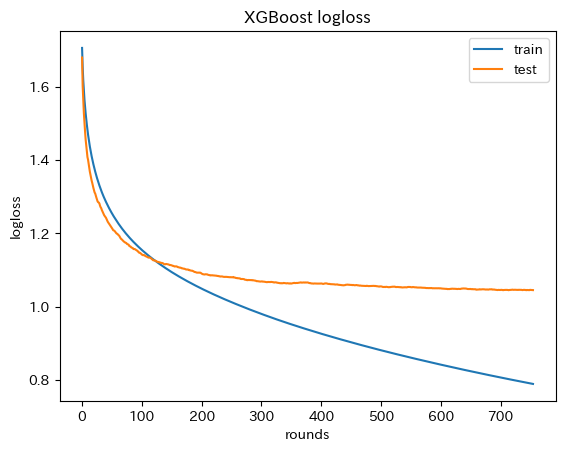

In [93]:
# Model
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.5,
}

history = dict()

# learning
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=50)

# prediciton
preds_labels = model.predict(test_data)

# Visualization
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

In [94]:
test_labels += 1
preds_labels += 1

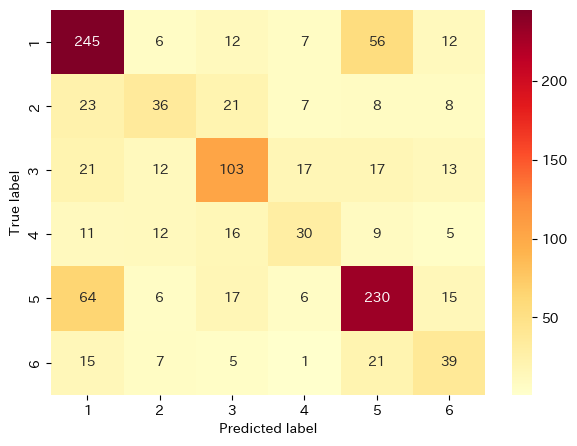

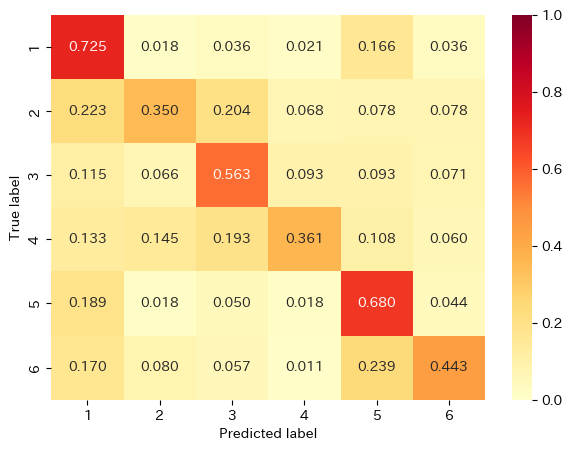

              precision    recall  f1-score   support

           1      0.646     0.725     0.683       338
           2      0.456     0.350     0.396       103
           3      0.592     0.563     0.577       183
           4      0.441     0.361     0.397        83
           5      0.674     0.680     0.677       338
           6      0.424     0.443     0.433        88

    accuracy                          0.603      1133
   macro avg      0.539     0.520     0.527      1133
weighted avg      0.596     0.603     0.598      1133



In [95]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

k = 6  
'cl-tohoku/bert-base-japanese-whole-word-masking' は accuracy 60%  
'cl-tohoku/bert-base-japanese-v2' は accuracy 58.6%

In [96]:
# 間違って予測された文章のindexを取得
wrong_preds = np.where(test_labels != preds_labels)[0]

# 間違って予測された文章を5個表示
for i in wrong_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

この性格の悪さを何とかしたい…
True label: 3
Predicted label: 5.0
---
職場でお寿司連れてってもらってお腹パンパン！デザートまで出してもらって大満足。苦しくなるほど食べられるなんて幸せじゃないか。
True label: 1
Predicted label: 3.0
---
友達がハワイで挙式して、森で撮った写真がすごく素敵で羨ましかった。長い髪はゆる巻きダウンにして、お花の冠とベールをつけてるかんじ。木漏れ日を見上げる姿が可愛かったなぁ。
True label: 5
Predicted label: 1.0
---
今日また、ふらりと入れる店が増えた。お酒もご飯も美味しかったし、何より、何となく温かい店だった。
True label: 4
Predicted label: 2.0
---
寒いってことに支配されて建設的な思考が奪われるから、冬は嫌い。
True label: 1
Predicted label: 5.0
---


---